# notes:
* tensorflow is very picky about the shape of data, so even you np.ndarray is `(47, )`, you need to reshape it into `(47,1)` to make sure everything goes alright
* the shape of `np.array([1,2,3,4])` is `(4, )`, this is column vector. Be aware of the shape of data.
* Different optimizer have very huge difference between convergence speed in this convex example, [I need to learn more about differences of optimizers](http://sebastianruder.com/optimizing-gradient-descent/)
* Confused about whether I should use row vector or column vector and here is the answer: [Column Vectors Vs. Row Vectors](http://steve.hollasch.net/cgindex/math/matrix/column-vec.html)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="darkgrid", palette="dark")

import sys
sys.path.append('..')

from helper import linear_regression as lr  # my own module
from helper import general as general

# prepare data

In [2]:
raw_data = pd.read_csv('ex1data2.txt', names=['square', 'bedrooms', 'price'])
data = general.normalize_feature(raw_data)

print(data.shape)
data.head()

(47, 3)


,square,bedrooms,price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


In [3]:
X_data = general.get_X(data)
print(X_data.shape, type(X_data))

y_data = general.get_y(data)
print(y_data.shape, type(y_data))

(47, 3) <class 'numpy.ndarray'>
(47, 1) <class 'numpy.ndarray'>


# run the tensorflow graph

In [6]:
%psource lr.linear_regression

workingo on Adam
Converged at epoch 291
final parameters
 [[  7.32150340e-10]
 [  8.83785844e-01]
 [ -5.24775721e-02]]
final loss=0.13068680465221405

workingo on Adagrad
final parameters
 [[  1.18540144e-09]
 [  6.29212141e-01]
 [  1.15501381e-01]]
final loss=0.15294454991817474

workingo on GD
Converged at epoch 1153
final parameters
 [[  1.69923842e-09]
 [  8.81530404e-01]
 [ -4.99432907e-02]]
final loss=0.13069100677967072

workingo on Ftrl
final parameters
 [[  1.10441267e-10]
 [  6.29321277e-01]
 [  1.15429334e-01]]
final loss=0.15294456481933594

workingo on RMS
Converged at epoch 243
final parameters
 [[ 0.00501032]
 [ 0.88974345]
 [-0.04820134]]
final loss=0.13073687255382538



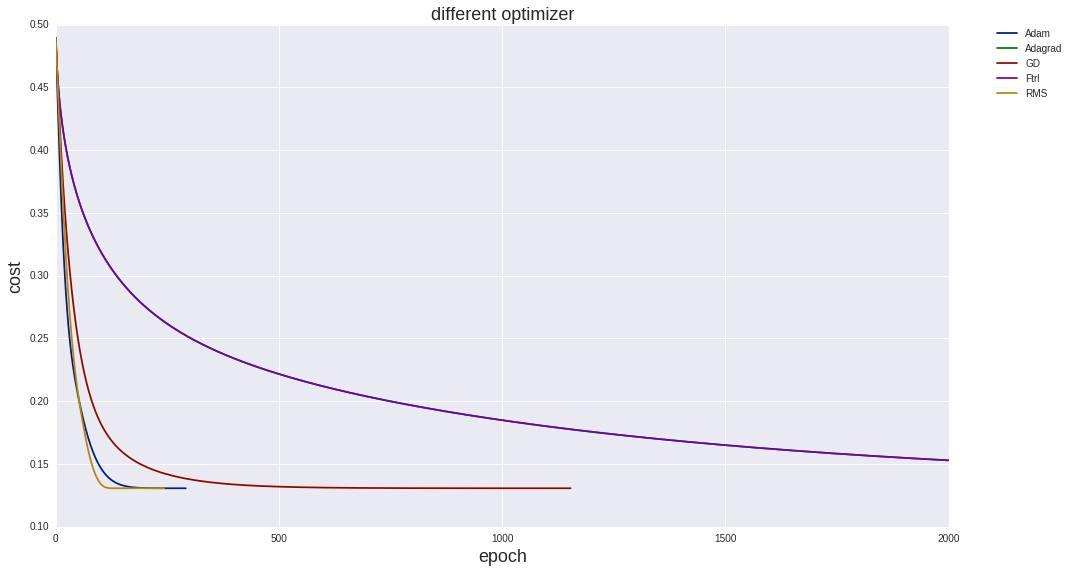

In [14]:
epoch = 2000
alpha = 0.01

optimizer_dict={'GD': tf.train.GradientDescentOptimizer,
                'Adagrad': tf.train.AdagradOptimizer,
                'Adam': tf.train.AdamOptimizer,
                'Ftrl': tf.train.FtrlOptimizer,
                'RMS': tf.train.RMSPropOptimizer
               }

fig, ax = plt.subplots(figsize=(16, 9))

for name in optimizer_dict:
    print('workingo on {}'.format(name))
    res = lr.linear_regression(X_data, y_data, alpha, epoch, optimizer=optimizer_dict[name])
    loss_data = res['loss']
    
    print('final parameters\n', res['parameters'])
    print('final loss={}\n'.format(loss_data[-1]))
    ax.plot(np.arange(len(loss_data)), loss_data, label=name)

ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('different optimizer', fontsize=18)
